In [9]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt


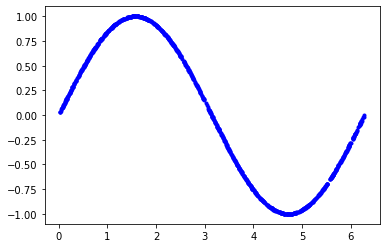

In [10]:
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this notebook
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Generate a uniformy distributed set of random numbers in the range from
# 0 to 2n, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to quarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b. ' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b. ')
plt.show()

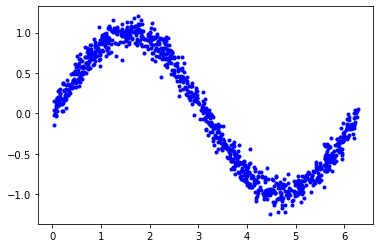

In [11]:
# add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b. ')
plt.show()

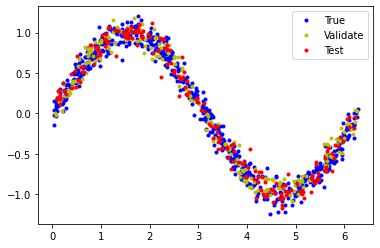

In [12]:
# We' ll use 60% of our data for trainig and 20% for testing. 20% for validation
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b. ', label="True")
plt.plot(x_validate, y_validate, 'y. ', label="Validate")
plt.plot(x_test, y_test, 'r. ', label="Test")
plt.legend()
plt.show()

In [4]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

In [5]:
# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# Get indexes of the input and output tensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

In [6]:
# Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

In [14]:
# Run each model's interpreter for each value and store the results in arrays
for x_value in x_test:
  # Create a 2D tensor wrapping the current x value
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  # Write the value to the input tensor
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  # Run inference
  sine_model.invoke()
  # Read the prediction from the output tensor
  sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])

  # Do the same for the quantized model
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


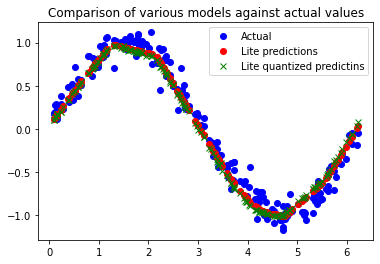

In [16]:
# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
#plt.plot(x_test, predictions, 'ro', label='Original_predictions')
plt.plot(x_test, sine_model_predictions, 'ro', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictins')
plt.legend()
plt.show()

In [17]:
import os

basic_model_size = os.path.getsize('sine_model.tflite')
print("Basic model is %d bytes" % basic_model_size)

quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 3140 bytes
Quantized model is 2976 bytes
Difference is 164 bytes
